In collaboration with Hayley Sussman and Anthony Bell. 

We will look at a dataset of wine reviews (https://www.kaggle.com/datasets/zynicide/wine-reviews). This data contains wine ratings from WineEnthusiast. We plan to analyze the relationships between several of the features of the wine and its rating. Ultimately our objective is to use several methods we’ve learned in class to perform analysis of the dataset.
 
We plan to use sentiment analysis to determine what words indicate better wine, and what words are not great predictors of wine quality. We plan to use a regression model to predict the rating of wine from the country and region it is from as well as the price.

# Libraries and Setup Jargon
Run the following cells to set up the notebook.

In [ ]:
# Versioning again
!pip install pandas==1.1.5
!pip install folium
!pip install geopy
!pip install tabulate

In [ ]:
# Sklearn and Pandas Setup
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
import folium 
import os 
import folium
from folium import plugins
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
!apt update
!apt install gcc python-dev libkrb5-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://security.ubuntu.

# EDA and Data Wrangling

### **EDA**

Exploratory Data Analysis (EDA) is an approach to analyzing data sets to summarize their main characteristics, often with visual methods. A statistical model can be used or not, but primarily EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing task.

For this portion of the project, we'll use EDA to analyze `winemag-data_first150k.csv` from [this Kaggle](https://www.kaggle.com/datasets/zynicide/wine-reviews) dataset.

In [ ]:
!pip install kaggle

In [ ]:
# Create the kaggle directory and read the uploaded kaggle.json file
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
# Download datasets
!kaggle datasets download -d zynicide/wine-reviews

 92% 47.0M/50.9M [00:01<00:00, 37.6MB/s]
100% 50.9M/50.9M [00:02<00:00, 18.9MB/s]


In [ ]:
# Unzip folder in Colab content folder
!unzip /content/wine-reviews.zip

Archive:  /content/wine-reviews.zip
  inflating: winemag-data-130k-v2.csv  
  inflating: winemag-data-130k-v2.json  
  inflating: winemag-data_first150k.csv  


In [ ]:
wine_reviews_df = pd.read_csv('winemag-data_first150k.csv', index_col=False)

Let's take a look at our data.

In [ ]:
wine_reviews_df.head()

Unnamed: 0 country                                        description  \
0           0      US  This tremendous 100% varietal wine hails from ...   
1           1   Spain  Ripe aromas of fig, blackberry and cassis are ...   
2           2      US  Mac Watson honors the memory of a wine once ma...   
3           3      US  This spent 20 months in 30% new French oak, an...   
4           4  France  This is the top wine from La Bégude, named aft...   

                            designation  points  price        province  \
0                     Martha's Vineyard      96  235.0      California   
1  Carodorum Selección Especial Reserva      96  110.0  Northern Spain   
2         Special Selected Late Harvest      96   90.0      California   
3                               Reserve      96   65.0          Oregon   
4                            La Brûlade      95   66.0        Provence   

            region_1           region_2             variety  \
0        Napa Valley               Napa  Cabernet Sauvignon   
1               Toro                NaN       Tinta de Toro   
2     Knights Valley             Sonoma     Sauvignon Blanc   
3  Willamette Valley  Willamette Valley          Pinot Noir   
4             Bandol                NaN  Provence red blend   

                    winery  
0                    Heitz  
1  Bodega Carmen Rodríguez  
2                 Macauley  
3                    Ponzi  
4     Domaine de la Bégude

In [ ]:
wine_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   150930 non-null  int64  
 1   country      150925 non-null  object 
 2   description  150930 non-null  object 
 3   designation  105195 non-null  object 
 4   points       150930 non-null  int64  
 5   price        137235 non-null  float64
 6   province     150925 non-null  object 
 7   region_1     125870 non-null  object 
 8   region_2     60953 non-null   object 
 9   variety      150930 non-null  object 
 10  winery       150930 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


On first glance, the column `Unnamed: 0` doesn't look very helpful, so let's drop that one. Only 40.4% of wines have a non-null `region_2` field (a more specific region within the wine-growing area). `region_1` is plenty information for us, so we'll delete `region_2` as well, and rename `region_1` to `region`.

In [ ]:
wine_reviews_df = wine_reviews_df.drop(columns=['Unnamed: 0', 'region_2'])
wine_reviews_df = wine_reviews_df.rename(columns={'region_1': 'region'})

Let's check out the data types we're working with.

In [ ]:
wine_reviews_df.dtypes

country         object
description     object
designation     object
points           int64
price          float64
province        object
region          object
variety         object
winery          object
dtype: object

To use most of these as features, we'll have to do some data wrangling. First let's do a bit more investigation and see some summary statistics for our numerical columns.

In [ ]:
wine_reviews_df.describe()

points          price
count  150930.000000  137235.000000
mean       87.888418      33.131482
std         3.222392      36.322536
min        80.000000       4.000000
25%        86.000000      16.000000
50%        88.000000      24.000000
75%        90.000000      40.000000
max       100.000000    2300.000000

We'll want to predict the wine rating, stored in the column `points` out of 100, so let's remove all the rows that have NaN in points. In addition, we notice that WineEnthusiast's ratings only range from 80 to 100. 

Actually, [this site](https://www.wine-searcher.com/critics-17-wine+enthusiast) gives a nice rundown of what WineEnthusiast's ratings actually mean:



> 98–100 – Classic

> 94–97 – Superb

> 90–93 – Excellent

> 87–89 – Very good

> 83–86 – Good

> 80–82 – Acceptable

Let's create a new columns called `rating` to store these string values.


In [ ]:
wine_reviews_df = wine_reviews_df.dropna(subset=['points'])

def points_to_rating(points):
  if points >= 98:
    return 'Classic'
  if points >= 94:
    return 'Superb'
  if points >= 90:
    return 'Excellent'
  if points >= 87:
    return 'Very good'
  if points >= 83:
    return 'Good'
  else:
    return 'Acceptable'

wine_reviews_df['rating'] = wine_reviews_df.apply(lambda x: points_to_rating(x['points']), axis=1)

### Investigating Wine Rating, Country of Origin, and Price

We have a hunch that WineEnthusiast might be a bit snobby and primarily enjoy expensive wines! We're interested in the correlation bewteen wine price and rating. Let's first check out that correlation using pandas pairwise correlation. 

In [ ]:
wine_reviews_df.corr()

points     price
points  1.000000  0.459863
price   0.459863  1.000000

And let's check this out visually! We'll first plot a heatmap showing the correlations.

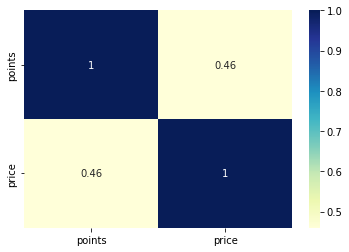

In [ ]:
# plotting correlation heatmap
dataplot = sns.heatmap(wine_reviews_df.corr(), cmap="YlGnBu", annot=True)

Now, we plot a bar chart that shows the mean price of wine in each country for each rating category. To keep this chart readable, let's check out how many countries this dataset has.

In [ ]:
wine_reviews_df.nunique()

country           48
description    97821
designation    30621
points            21
price            357
province         455
region          1236
variety          632
winery         14810
rating             6
dtype: int64

In [ ]:
wine_reviews_df.country.unique()

array(['US', 'Spain', 'France', 'Italy', 'New Zealand', 'Bulgaria',
       'Argentina', 'Australia', 'Portugal', 'Israel', 'South Africa',
       'Greece', 'Chile', 'Morocco', 'Romania', 'Germany', 'Canada',
       'Moldova', 'Hungary', 'Austria', 'Croatia', 'Slovenia', nan,
       'India', 'Turkey', 'Macedonia', 'Lebanon', 'Serbia', 'Uruguay',
       'Switzerland', 'Albania', 'Bosnia and Herzegovina', 'Brazil',
       'Cyprus', 'Lithuania', 'Japan', 'China', 'South Korea', 'Ukraine',
       'England', 'Mexico', 'Georgia', 'Montenegro', 'Luxembourg',
       'Slovakia', 'Czech Republic', 'Egypt', 'Tunisia', 'US-France'],
      dtype=object)

48 countries is quite a few. Let's plot the values for the top 5 countries we have the most data for.

In [ ]:
wine_reviews_df.country.value_counts().head()

US        62397
Italy     23478
France    21098
Spain      8268
Chile      5816
Name: country, dtype: int64

(0.0, 800.0)

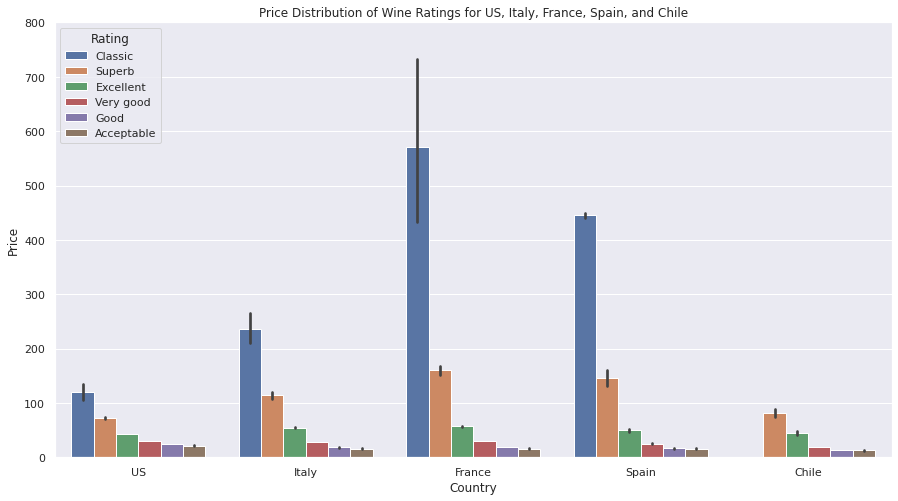

In [ ]:
countries = ['US', 'Italy', 'France', 'Spain', 'Chile']
ratings = ['Classic', 'Superb', 'Excellent', 'Very good', 'Good', 'Acceptable']

sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(x='country', y='price', hue='rating', order=countries, hue_order=ratings, data=wine_reviews_df)
plt.title('Price Distribution of Wine Ratings for US, Italy, France, Spain, and Chile')
plt.legend(title='Rating', loc='upper left')
plt.xlabel('Country')
plt.ylabel('Price')
plt.ylim(0, 800)


Interestingly, when we set the y-axis to a logistic scale, we get a more linear distribution.

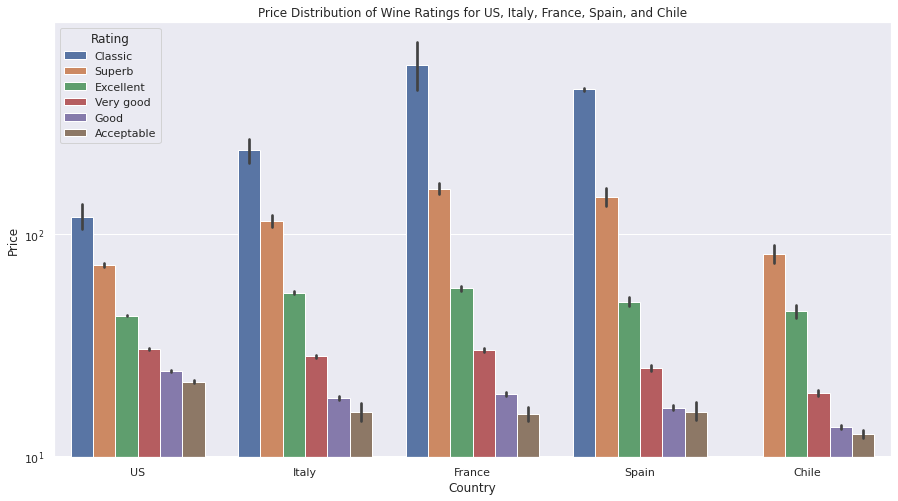

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(x='country', y='price', hue='rating', order=countries, hue_order=ratings, data=wine_reviews_df)
plt.title('Price Distribution of Wine Ratings for US, Italy, France, Spain, and Chile')
plt.legend(title='Rating', loc='upper left')
plt.xlabel('Country')
plt.ylabel('Price')
plt.yscale('log')

Our hunch was right! Price is definitely correlated with rating, across each of the top 5 countries in this dataset. Later on, it'll be interesting to see if we can train a model to predict rating based on price and other wine features.

Finally, let's create a new column for `continent` of origin of the wines. We saw earlier that the countries are:
`['US', 'Spain', 'France', 'Italy', 'New Zealand', 'Bulgaria',
       'Argentina', 'Australia', 'Portugal', 'Israel', 'South Africa',
       'Greece', 'Chile', 'Morocco', 'Romania', 'Germany', 'Canada',
       'Moldova', 'Hungary', 'Austria', 'Croatia', 'Slovenia', nan,
       'India', 'Turkey', 'Macedonia', 'Lebanon', 'Serbia', 'Uruguay',
       'Switzerland', 'Albania', 'Bosnia and Herzegovina', 'Brazil',
       'Cyprus', 'Lithuania', 'Japan', 'China', 'South Korea', 'Ukraine',
       'England', 'Mexico', 'Georgia', 'Montenegro', 'Luxembourg',
       'Slovakia', 'Czech Republic', 'Egypt', 'Tunisia', 'US-France']`

We'll manually create a list for each continent which includes the countries belonging to it. We'll include `US-France` in `europe` for simplicity, and choose to include countries between the border of two continents in the continent which it most closely culturally and historically aligns with or which continent contains more of its land (specifically Cyprus and Georgia in Europe, and Turkey in `asia`).

In [ ]:
north_america = ['US', 'Canada', 'US-France', 'Mexico']
south_america = ['Argentina', 'Chile', 'Uruguay', 'Brazil']
europe = ['Spain', 'US-France','France', 'Italy', 'Bulgaria', 'Portugal', 'Greece', 'Romania', 'Germany'
          'Moldova', 'Hungary', 'Austria', 'Croatia', 'Slovenia', 'Macedonia', 'Switzlerand',
          'Albania', 'Bosnia and Herzegovina', 'Cyprus', 'Lithuania', 'Ukraine', 'England',
          'Montenegro', 'Luxembourg', 'Slovakia', 'Czech Republic', 'Turkey', 'Serbia',  'Georgia']
africa = ['South Africa', 'Morocco', 'Tunisia', 'Egypt']
asia = ['Israel', 'Lebanon', 'Japan', 'China', 'South Korea', 'India', 'Turkey', 'Lebanon']
oceania = ['New Zealand', 'Australia']

Now we'll create a new column in our `wine_reviews_df` for `continent` using the lists constructed above and the dataframe's `country` column. Before doing so, we'll make sure to drop any rows with a null `country`.

In [ ]:
wine_reviews_df = wine_reviews_df.dropna(subset=['country'])

def country_to_continent(country):
  if country in north_america:
    return 'North America'
  if country in south_america:
    return 'South America'
  if country in europe:
    return 'Europe'
  if country in asia:
    return 'Asia'
  if country in oceania:
    return 'Oceania'
  else:
    return 'Africa'

wine_reviews_df['continent'] = wine_reviews_df.apply(lambda x: country_to_continent(x['country']), axis=1)

In [ ]:
wine_reviews_df.head()

country                                        description  \
0      US  This tremendous 100% varietal wine hails from ...   
1   Spain  Ripe aromas of fig, blackberry and cassis are ...   
2      US  Mac Watson honors the memory of a wine once ma...   
3      US  This spent 20 months in 30% new French oak, an...   
4  France  This is the top wine from La Bégude, named aft...   

                            designation  points  price        province  \
0                     Martha's Vineyard      96  235.0      California   
1  Carodorum Selección Especial Reserva      96  110.0  Northern Spain   
2         Special Selected Late Harvest      96   90.0      California   
3                               Reserve      96   65.0          Oregon   
4                            La Brûlade      95   66.0        Provence   

              region             variety                   winery  rating  \
0        Napa Valley  Cabernet Sauvignon                    Heitz  Superb   
1               Toro       Tinta de Toro  Bodega Carmen Rodríguez  Superb   
2     Knights Valley     Sauvignon Blanc                 Macauley  Superb   
3  Willamette Valley          Pinot Noir                    Ponzi  Superb   
4             Bandol  Provence red blend     Domaine de la Bégude  Superb   

       continent  
0  North America  
1         Europe  
2  North America  
3  North America  
4         Europe

### **Visualizing wine ratings and price in the US with an interactive map**

Remember the common mantra of real estate: location, location, location! We're curious about the correlation between location and price within a single country. This dataset has the most data for the US, so we'll create a map to show rating distribution of wines across the US. Specifically, we'll create a map with a marker for each state, where the marker displays information about how many wine datapoints we have for the state, along with the average rating and price of wines in that state.

First, let's isolate our US wine data by obtaining `us_reviews_df` which only contains reviews where `country == US`. We're also interested in wines with a designated state, and states are stored in the `province` columns, so let's drop all rows with a null `province`.

In [ ]:
us_reviews_df = wine_reviews_df[wine_reviews_df['country'] == 'US']
us_reviews_df = us_reviews_df.dropna(subset=['province'])

Let's check out the unique values that `province` takes and make sure we're only keeping ones that correspond with US states.

In [ ]:
province_list = set(us_reviews_df['province'].tolist())
province_list

{'America',
 'Arizona',
 'California',
 'Colorado',
 'Connecticut',
 'Idaho',
 'Iowa',
 'Kentucky',
 'Massachusetts',
 'Michigan',
 'Missouri',
 'Nevada',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'Ohio',
 'Oregon',
 'Pennsylvania',
 'Texas',
 'Vermont',
 'Virginia',
 'Washington',
 'Washington-Oregon'}

"America" isn't a state, so let's go ahead and remove rows where `province == 'America'`. It's also not obvious what state the wines with "Washington-Oregon" belong to, so let's remove those as well.

In [ ]:
us_reviews_df = us_reviews_df[us_reviews_df.province != 'America']
us_reviews_df = us_reviews_df[us_reviews_df.province != 'Washington-Oregon']

We're interested in the aggregate values across each state. Let's perform a group by to obtain a new dataframe grouped by `province`, and keep the mean value of `points` and `price`.

In [ ]:
state_reviews_df = us_reviews_df.groupby(by='province').mean()
state_reviews_df.head()

points      price
province                         
Arizona      84.897436  27.684211
California   87.682731  35.506042
Colorado     84.366667  22.533333
Connecticut  83.500000  14.000000
Idaho        85.477941  20.294118

We also want to keep the number of datapoints for each state. Let's create a new dataframe grouped by province that keeps the `count`, and then join this with `states_df` above.

In [ ]:
state_counts_df = us_reviews_df.groupby(by='province').count()[['points']].rename(columns={'points': 'count'})
state_reviews_df['count'] = state_counts_df['count']
state_reviews_df.reset_index(inplace=True)
state_reviews_df = state_reviews_df.rename(columns={'province': 'state'})

In [ ]:
state_reviews_df.head()

state     points      price  count
0      Arizona  84.897436  27.684211     39
1   California  87.682731  35.506042  44508
2     Colorado  84.366667  22.533333     30
3  Connecticut  83.500000  14.000000      2
4        Idaho  85.477941  20.294118    136

We'll be creating the map with a Python library called Folium. In order to map each state, we'll need the latitude and longitude of the state. Let's use a Python library called GeoPy for geocoding: converting the `province` column into values for new `latitude` and `longitude` columns.

In [ ]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="wine_reviews")

# Obtain a tuple (city, state, (lat, lon)) for each row
state_reviews_df['coord'] = state_reviews_df['state'].apply(geolocator.geocode)

# Isolate the lat and lon from the tuple
state_reviews_df['coord'] = state_reviews_df['coord'].apply(lambda x: (x.latitude, x.longitude))

state_reviews_df.head()

state     points      price  count                      coord
0      Arizona  84.897436  27.684211     39   (34.395342, -111.763275)
1   California  87.682731  35.506042  44508  (36.7014631, -118.755997)
2     Colorado  84.366667  22.533333     30  (38.7251776, -105.607716)
3  Connecticut  83.500000  14.000000      2  (41.6500201, -72.7342163)
4        Idaho  85.477941  20.294118    136  (43.6447642, -114.015407)

In [ ]:
import folium 

m = folium.Map(location=[39.8283, -98.5795], zoom_start=4, control_scale=True)

for i in range(0,len(state_reviews_df)):
   folium.Marker(
      location=[state_reviews_df.iloc[i]['coord'][0], state_reviews_df.iloc[i]['coord'][1]],
      popup=f"State: {state_reviews_df['state'][i]}, average price: {state_reviews_df['price'][i]}, average points: {state_reviews_df['points'][i]}",
      icon=folium.Icon(color='blue', icon_color='white', icon='glass', angle=0, prefix='fa')
   ).add_to(m)

m

# **Feature Engineering**

Feature engineering is the process of applying domain knowledge to extract features from raw data via data mining techniques. These features can be used to improve the performance of machine learning algorithms.

## Ranking System for Ordinal Encoding of Ratings

The `rating` column we created above contains information on the wine rating. In order to make the data useful as our target variable, we encode these ratings using _Ordinal Encoding_, since this categorial variable has a natural rank ordering. We'll create a new column called `numeric_rating` that contains these ordinal encodings (ranks).

**Clarifications**:
- We'll rank the ratings according to: `Classic > Superb > Excellent > Very good > Good > Acceptable`
- If the rating is `Acceptable`, assign the lowest rank of 0 to it.

In [ ]:
ordinal_encoding = {'Acceptable': 0, 'Good': 1, 'Very good': 2, 'Excellent': 3,
                    'Superb': 4, 'Classic': 5}

wine_reviews_df['numeric_rating'] = wine_reviews_df['rating'].apply(lambda x: ordinal_encoding[x.strip()])

### Label-Encode Categorial Data

In [ ]:
wine_reviews_df.nunique()

country              48
description       97818
designation       30618
points               21
price               357
province            455
region             1236
variety             632
winery            14809
rating                6
continent             6
numeric_rating        6
dtype: int64

Most of these categorical variables take on too many values to really encode as numerical. Let's see if we can limit the range of `province` and `region` by examining only a subset of wine reviews, namely those from the country with the most data: `US`.

In [ ]:
us_reviews_df.nunique()

country            1
description    40509
designation    11231
points            21
price            149
province          22
region           265
variety          218
winery          4759
rating             6
continent          1
dtype: int64

### Encoding Continents

We now convert the continents to ordinal codes using heat based encoding, since we hypothesize that heat is one of the most important metrics affecting [wine quality and growth](https://e360.yale.edu/features/what_global_warming_may_mean_for_worlds_wine_industry#:~:text=Warmer%20temperatures%20in%20general%20tend,of%20robust%2C%20fruitier%20wines.)). This is done with We use this encoding by approximating from the [country average temperature](https://en.wikipedia.org/wiki/List_of_countries_by_average_yearly_temperature) ranking.


**Clarifications**:
- We'll rank the ratings according to: `Africa > South America > Oceania > Asia > Europe > North America`
- If the rating is `North America`, assign the lowest rank of 0 to it.

In [ ]:
wine_reviews_df
# Creating a continent column indexed from Cold to Warm
continent_mapper = {"North America":0, "Europe": 1, "Asia": 2, "Oceania": 3, "South America": 4, "Africa": 5}
wine_reviews_df['continent_num'] = wine_reviews_df['continent'].replace(continent_mapper)


### Encoding Countries

We now encode countries by using a similar encoding system to above.

In [ ]:
wine_reviews_df['country'].unique()

array(['US', 'Spain', 'France', 'Italy', 'New Zealand', 'Bulgaria',
       'Argentina', 'Australia', 'Portugal', 'Israel', 'South Africa',
       'Greece', 'Chile', 'Morocco', 'Romania', 'Germany', 'Canada',
       'Moldova', 'Hungary', 'Austria', 'Croatia', 'Slovenia', 'India',
       'Turkey', 'Macedonia', 'Lebanon', 'Serbia', 'Uruguay',
       'Switzerland', 'Albania', 'Bosnia and Herzegovina', 'Brazil',
       'Cyprus', 'Lithuania', 'Japan', 'China', 'South Korea', 'Ukraine',
       'England', 'Mexico', 'Georgia', 'Montenegro', 'Luxembourg',
       'Slovakia', 'Czech Republic', 'Egypt', 'Tunisia', 'US-France'],
      dtype=object)

Since we want to build a manual rating of the countries on heat and have entries like `England` which aren't recognized as countries, we will first implement a manual assignment dictionary using our earlier link rating system and then develop a classification system.

In [ ]:
# Creating a country column indexed from Cold to Warm using the average temperature listing
country_mapper = {'US': 13, 'Spain' : 29, 'France': 23, 'Italy': 30, 'New Zealand': 28, 'Bulgaria': 21,
       'Argentina': 37, 'Australia': 38, 'Portugal': 31, 'Israel': 36, 'South Africa': 33,
       'Greece': 31, 'Chile': 11, 'Morocco': 32, 'Romania': 16, 'Germany': 10, 'Canada': 1,
       'Moldova': 16, 'Hungary': 17, 'Austria': 5, 'Croatia': 25, 'Slovenia': 15, 'India': 40,
       'Turkey': 20, 'Macedonia': 18, 'Lebanon': 33, 'Serbia': 21, 'Uruguay': 33,
       'Switzerland': 2, 'Albania': 27, 'Bosnia and Herzegovina': 19, 'Brazil': 41,
       'Cyprus': 34, 'Lithuania': 4, 'Japan': 26, 'China': 7, 'South Korea': 28, 'Ukraine': 9,
       'England': 12, 'Mexico': 41, 'Georgia': 3, 'Montenegro': 22, 'Luxembourg': 14,
       'Slovakia': 6, 'Czech Republic': 8, 'Egypt': 39, 'Tunisia' : 35, 'US-France': 24}
wine_reviews_df['country_num'] = wine_reviews_df['country'].replace(country_mapper)

In [ ]:
sort_orders = sorted(country_mapper.items(), key=lambda x: x[1], reverse=True)

for i in sort_orders:
	print(i[0], i[1])

Brazil 41
Mexico 41
India 40
Egypt 39
Australia 38
Argentina 37
Israel 36
Tunisia 35
Cyprus 34
South Africa 33
Lebanon 33
Uruguay 33
Morocco 32
Portugal 31
Greece 31
Italy 30
Spain 29
New Zealand 28
South Korea 28
Albania 27
Japan 26
Croatia 25
US-France 24
France 23
Montenegro 22
Bulgaria 21
Serbia 21
Turkey 20
Bosnia and Herzegovina 19
Macedonia 18
Hungary 17
Romania 16
Moldova 16
Slovenia 15
Luxembourg 14
US 13
England 12
Chile 11
Germany 10
Ukraine 9
Czech Republic 8
China 7
Slovakia 6
Austria 5
Lithuania 4
Georgia 3
Switzerland 2
Canada 1


## Pair plotting 

For some further EDA, let's visualize some pairwise relationships between variables in our dataset.

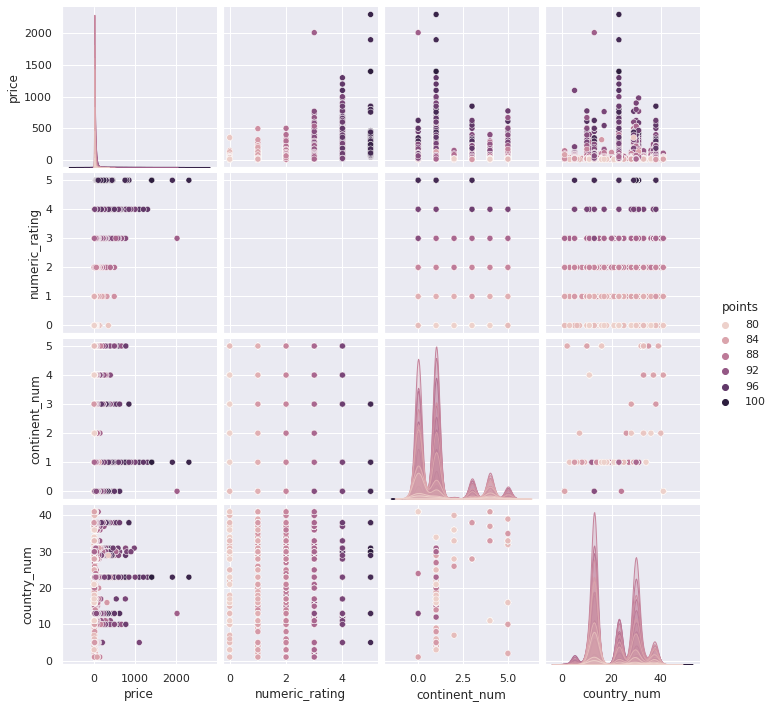

In [ ]:
sns.pairplot(wine_reviews_df, hue ='points')
plt.show()

## Encoding for Binary Classification

We now use binary classification to encode the various variables and build a more complete dataset. We'll use the median ratings (2, 3) as the partition around which to divide the rest of the values. From our earlier plots, we know that this is the 75th percentile of values and hence we can assume this to be a good label differentiation.

In [ ]:
conditions = [
    (wine_reviews_df['numeric_rating'] >= 3),
    (wine_reviews_df['numeric_rating'] < 3)
    ]

values = [1, 0]

wine_reviews_df['label']  = np.select(conditions, values) 

We shall now visualize the continent counts with regard to our main target variable, which is the binary classifier value.

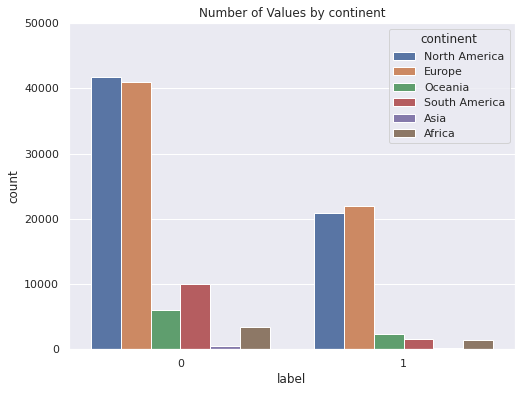

In [ ]:
fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='label', data=wine_reviews_df, hue='continent')
ax.set_ylim(0,50000)
plt.title("Number of Values by continent")
plt.show()

# Modelling Using Numeric Data


We now aim to predict which types of ML models will do better at the text data we have, and we run regressions across multiple variables to give us a better understanding of the different types of wine types depending on the continent/country order.

## Encoding Data and Splitting Dataset

## Preprocessing: Split into Features and Label

Now that we have explored and cleaned our dataset, we can prepare it for the ML task. We have converted the numeric ratings to binary labels above, and therefore will predict using the binary variable for classification, and then will require additional work to finalize.

The features will be the encoded variable together with some other attributes: `continent_num`, `country_num`.

In [ ]:
wine_reviews_df.replace([np.inf, -np.inf], np.nan, inplace=True)
wine_reviews_df.dropna(subset=['country_num', 'continent_num','price', 'label'], inplace=True)
price_features = wine_reviews_df[["country_num", "continent_num","points"]]

# TO-DO: store the binary classification target variable into "labels"
labels = wine_reviews_df['label']
wine_reviews_df['price'] = wine_reviews_df['price'].astype(int)
# TO-DO: store the regression target variable into "prices"
prices = wine_reviews_df['price']

wine_reviews_df.dtypes

country           object
description       object
designation       object
points             int64
price              int64
province          object
region            object
variety           object
winery            object
rating            object
continent         object
numeric_rating     int64
continent_num      int64
country_num        int64
label              int64
dtype: object

### Splitting Train-Test Data

Use scikit-learn's train_test_split function to split data for regression into train and test sets. The split would be 80-20 meaning 80% for training and rest for testing.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

x_train, x_test, y_train, y_test = train_test_split(price_features, prices, test_size=0.2, random_state=42)

## Linear Regression

We use the `Linear Regression` class to model the changes with regard to price.

In [ ]:
from sklearn.metrics import r2_score
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
score = model.score(x_test, y_test)
print(r2_score(y_test, y_pred))

0.23204570000430402


## Ridge Regression

Linear Regression does not seem to be very effective, with a test accuracy of only 23.2%. We now implement Ridge Regression to see if it will help make us better predictions on the test data.

In [ ]:
sc = StandardScaler()
x_train_sc = sc.fit_transform(x_train)
xt = sc.transform(x_test)

clf = Ridge(alpha=1.0)
clf.fit(x_train_sc, y_train)
ridge_score = clf.score(xt, y_test)
ridge_score

0.2320457319947461

## Lasso Regression

Ridge does seem to be much better, so we now implement lasso regression to better develop our model.

In [ ]:
sc = StandardScaler()
x_train_sc = sc.fit_transform(x_train)
xt = sc.transform(x_test)

# Your code here
clf = Lasso(alpha=1.0)
clf.fit(x_train, y_train)
lasso_score = clf.score(x_test, y_test)
lasso_score

0.23150194864741602

This is not much better either, suggesting that for our features there was no need for regularization to achieve better accuracy.

## Classifications based on Label

We now split the data based on label, using our classifier to better classify and implement the data to help us classify our labels.

We first split our data into train/test sets, following which we scale using PCA and then train various models on the data.

In [ ]:
main_features = wine_reviews_df[["country_num", "continent_num", "price"]]
x_train, x_test, y_train, y_test = train_test_split(main_features, labels, test_size=0.2, random_state=42)

### Scaling wtih PCA

In [ ]:
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

x = StandardScaler().fit_transform(x_train)
pca = PCA(n_components=len(x_train.columns))
pca.fit(x)

PCA(n_components=3)

In [ ]:
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = np.cumsum(explained_variance_ratios)

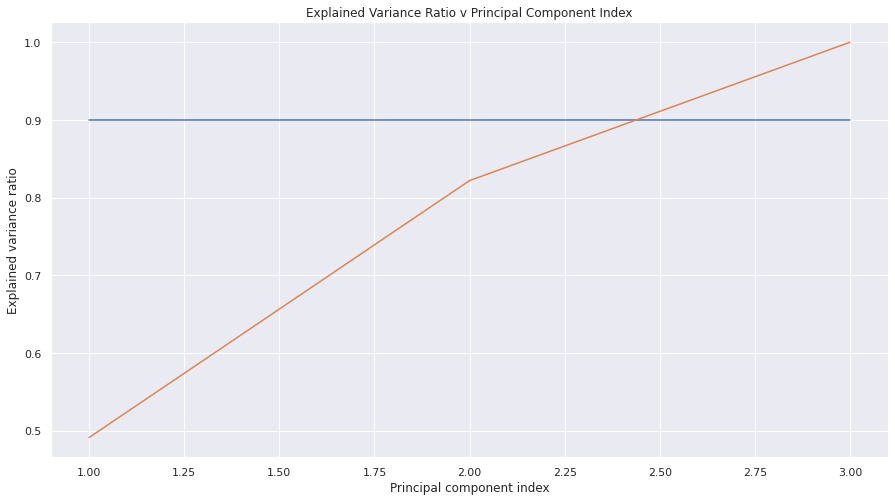

In [ ]:
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('Explained Variance Ratio v Principal Component Index')
plt.plot(np.arange(1, 4), [0.90]*3)
plt.plot(np.arange(1, 4), np.cumsum(pca.explained_variance_ratio_))
plt.show()

### Visualizing 2-Component PCA

We now use a 2-compoent PCA to better visualize the relations between them.

In [ ]:
pca = PCA(n_components=2)
pca.fit(x)
xt = StandardScaler().fit_transform(x_test)
x_test_pca = pca.transform(xt)

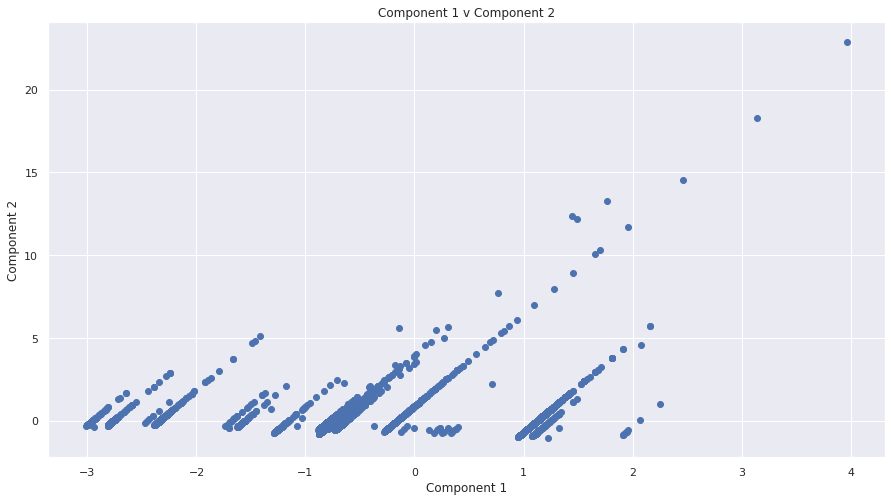

In [ ]:
pca2 = PCA(n_components=2)
train_modified_df = x_train.head(5000)
x_train_sc_mod = StandardScaler().fit_transform(train_modified_df)
components = pca2.fit_transform(x_train_sc_mod)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title('Component 1 v Component 2')
xcomp, ycomp = components.T
plt.scatter(xcomp, ycomp)

## Logistic Regression

Since we wanted to do a binary classification, we use a first attempt logistic regression to see our score with the logistic regression model.

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(penalty = 'l2')
xv = pca.transform(x)
logreg.fit(xv, y_train)
log_pred = logreg.predict(x_test_pca)

# Precision
log_precision = precision_score(y_test, log_pred)

# Recall
log_recall = recall_score(y_test, log_pred)

# F1 score
log_f1 = f1_score(y_test, log_pred)
log_test_accuracy = logreg.score(x_test_pca, y_test)

print(f'Accuracy for Logistic Regression: {log_test_accuracy}')
print(f'Precision for Logistic Regression: {log_precision}')
print(f'Recall for  Logistic Regression: {log_recall}')
print(f'F1 for  Logistic Regression: {log_f1}')

Accuracy for Logistic Regression: 0.7728266414049406
Precision for Logistic Regression: 0.7242134607726005
Recall for  Logistic Regression: 0.42853776363850593
F1 for  Logistic Regression: 0.5384558442519801


## Random Forest Classifier Model

Our Logistic Regression model achieves a pretty good test accuracy! We now use a Random Forest Model to better improve for our classifier and achieve a higher predictive accuracy, and hopefully better performance metrics all around.

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators = 100)
# Train the model on training data
rf.fit(x_train, y_train)

RandomForestClassifier()

In [ ]:
# Use the forest's predict method on the test data
rf_pred = rf.predict(x_test)
# Precision
rf_num_precision = precision_score(y_test, rf_pred)

# Recall
rf_num_recall = recall_score(y_test, rf_pred)

# F1 score
rf_num_f1 = f1_score(y_test, rf_pred)
rf_num_accuracy = rf.score(x_test, y_test)

print(f'Accuracy for Random Forest Classifier: {rf_num_accuracy}')
print(f'Precision for Random Forest Classifier: {rf_num_precision}')
print(f'Recall for  Random Forest Classifier: {rf_num_recall}')
print(f'F1 for  Random Forest Classifier: {rf_num_f1}')

Accuracy for Random Forest Classifier: 0.7831742330394229
Precision for Random Forest Classifier: 0.6882422802850356
Recall for  Random Forest Classifier: 0.5462472016024508
F1 for  Random Forest Classifier: 0.6090783682585561


We do slightly better than our Logistic Regression Model! Let's hope we can further improve with a tuning improvement. But first, a visualization of our random forest.

In [ ]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = x_train.columns, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

### Visualizing Decision Tree

We now visualize a single decision tree from our random forest.

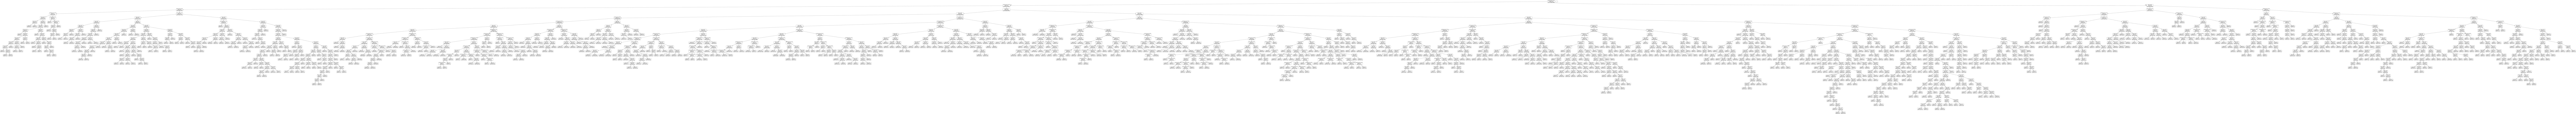

In [ ]:
from IPython.display import Image
im = Image('tree.png')
im

## Using RandomizedSearchCV to improve Model

We will now use RandomizedSearchCV to best tune our hyperparameters and form the best version of the model possible.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
x_train_grid = preprocessing.scale(x_train)
param_grid = { 
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
rfc=RandomForestClassifier(random_state=42)

CV_rfc = RandomizedSearchCV(estimator=rfc, param_distributions=param_grid, cv= 5)
CV_rfc.fit(x_train_grid, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 5, 6, 7, 8],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]})

In [ ]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 200}

In [ ]:
x_test_grid = preprocessing.scale(x_test)
pred=CV_rfc.predict(x_test_grid)

In [ ]:
print("Accuracy for Random Forest on CV data: ", CV_rfc.score(x_test_grid,y_test))

Accuracy for Random Forest on CV data:  0.7818261313123952


We don't do much better than before! This shows that the performance was not very dependent on the parameters of the random forest as the input data was not very multidimensional.

## Gradient Boosted Classifier

Finally, we implement a gradient boosted classifier as a final comparisont to the various earlier classifiers.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
clf.fit(x_train, y_train)
clf_pred = clf.predict(x_test)

# Precision
gbc_precision = precision_score(y_test, clf_pred)

# Recall
gbc_recall = recall_score(y_test, clf_pred)

# F1 score
gbc_f1 = f1_score(y_test, clf_pred)
gbc_accuracy = clf.score(x_test, y_test)

print(f'Accuracy for Gradient Boosted Classifier: {gbc_accuracy}')
print(f'Precision for Gradient Boosted Classifier: {gbc_precision}')
print(f'Recall for Gradient Boosted Classifier: {gbc_recall}')
print(f'F1 for Gradient Boosted Classifier: {gbc_f1}')

Accuracy for Gradient Boosted Classifier: 0.7826277053122495
Precision for Gradient Boosted Classifier: 0.6830259909975316
Recall for Gradient Boosted Classifier: 0.5542594556380347
F1 for Gradient Boosted Classifier: 0.6119422401457005


This also does similarly well! It seems that 78% is the highest predictive accuracy we can achieve with our model.

## Comparison of Numeric Classifiers

Now that we've trained and evaluated each of our three numeric classifiers, let's see how they compare on each performance metric. We'll use the Python `tabulate` to format a table containing the accuracy, F1, precision, and recall for our three classifiers.

In [ ]:
table = [['', 'Logistic Regression', 'Random Forest Regression', 'GBC'], 
         ['Accuracy', log_test_accuracy, rf_num_accuracy, gbc_accuracy], 
         ['Precision', log_precision, rf_num_precision, gbc_precision],
         ['Recall', log_recall, rf_num_recall, gbc_recall],
         ['F1', log_f1, rf_num_f1, gbc_f1]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════╤═══════════════════════╤════════════════════════════╤══════════╕
│           │   Logistic Regression │   Random Forest Regression │      GBC │
╞═══════════╪═══════════════════════╪════════════════════════════╪══════════╡
│ Accuracy  │              0.772827 │                   0.783174 │ 0.782628 │
├───────────┼───────────────────────┼────────────────────────────┼──────────┤
│ Precision │              0.724213 │                   0.688242 │ 0.683026 │
├───────────┼───────────────────────┼────────────────────────────┼──────────┤
│ Recall    │              0.428538 │                   0.546247 │ 0.554259 │
├───────────┼───────────────────────┼────────────────────────────┼──────────┤
│ F1        │              0.538456 │                   0.609078 │ 0.611942 │
╘═══════════╧═══════════════════════╧════════════════════════════╧══════════╛


Not bad for test accuracy across the three models! Our recall values were particularly low. This might be an outcome of untuned model hyperparameters, but it's also likely this is an outcome of imbalanced class; we had far more wines labeled with 0 than 1, and all classifiers had lower recall than other performance metrics.

# **Working with Text Data: Wine Description Analysis**

We'll try to do some text-based analysis on the wine descriptions and see what sorts of conclusions we can make. 

Throughout this section, we will attempt to answer the following question:

**How do descriptions of well-rated wines differ from descriptions of mediocre wines?**


###Extract Data
Using our earlier labels, we'll partition `wine_reviews_df` into two dataframes:
* `great_wines_df`: where `label == 1` (the 75th percentile of wine ratings).
* `mediocre_wines_df`: where `label == 0`.

Then, for each dataframe, we'll convert the `description` column into two lists called `great_content` and `mediocre_content`, respectively. `great_content` will contain descriptions of well-rated wines, and `mediocre_content` descriptions of mediocre wines.

In [ ]:
great_wines_df = wine_reviews_df[wine_reviews_df['label'] == 1]
mediocre_wines_df = wine_reviews_df[wine_reviews_df['label'] == 0]

great_content = great_wines_df['description'].tolist()
mediocre_content = mediocre_wines_df['description'].tolist()

## Tokenize the Text

We'll split up the content of each wine description into a list of words. We will use the **nltk** package, which contains an extensive set of tools to process text. We will use the following:
- `nltk.word_tokenize()`: a function used to tokenize our text
- `nltk.corpus.stopwords`: a list of commonly used words such as "a","an","in" that are often ignored in text-related analysis.

We'll first use **stopwords** to create a set of the most common english stopwords. Then **tokenized_content(content)** will takes in a wine description string and:
1. Tokenize the text
2. Lowercase the token
3. Remove stop words (commonly used words such as "a","an", "in")
4. Keep words with only alphabet characters (no punctuation)

In [ ]:
import nltk
nltk.download('punkt')
from wordcloud import WordCloud
nltk.__version__

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


'3.2.5'

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
# Note that stopwords are all in lowercase format

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def tokenized_content(content):
  tokens = nltk.word_tokenize(content)
  return [x.lower() for x in tokens if x.lower() not in stopwords and x.isalpha()]

Now, we'll apply the `tokenize_content()` function to each wine description in **great_content** and **mediocre_content** and flatten both of the lists to create **great_tokens** and **medicore_tokens**


In [ ]:
great_tokens = []
for content in great_content:
  tokens = tokenized_content(content)
  for token in tokens:
    great_tokens.append(token)

mediocre_tokens = []
for content in mediocre_content:
  tokens = tokenized_content(content)
  for token in tokens:
    mediocre_tokens.append(token)


In [ ]:
print(f'There are {len(great_tokens)} great tokens and {len(mediocre_tokens)} mediocre tokens')

There are 1181505 great tokens and 2082139 mediocre tokens


### Most Frequent Words
We want to figure out which words describe great wines and which describe mediocre wines. To begin, we'll find the 20 most common words amongst the content of `great_tokens` and `medicore_tokens`. We return this as a list of `(word, count)` tuples, in descending order of `count`.

In [ ]:
import collections
great_counter = collections.Counter(great_tokens)
great_most_common = sorted(great_counter.most_common(20),  key = lambda x: x[1], reverse=True)

mediocre_counter = collections.Counter(mediocre_tokens)
mediocre_most_common = sorted(mediocre_counter.most_common(20),  key = lambda x: x[1], reverse=True)

In [ ]:
great_most_common

[('wine', 29051),
 ('flavors', 20852),
 ('fruit', 17880),
 ('tannins', 11744),
 ('finish', 10250),
 ('black', 10163),
 ('rich', 9729),
 ('acidity', 9502),
 ('ripe', 9455),
 ('cherry', 9309),
 ('drink', 8501),
 ('aromas', 8401),
 ('spice', 7747),
 ('years', 7716),
 ('palate', 7597),
 ('oak', 7086),
 ('dry', 6510),
 ('notes', 5911),
 ('shows', 5755),
 ('blackberry', 5528)]

In [ ]:
mediocre_most_common

[('flavors', 53220),
 ('wine', 49362),
 ('fruit', 32653),
 ('finish', 25744),
 ('aromas', 24197),
 ('palate', 20184),
 ('cherry', 19310),
 ('acidity', 18905),
 ('tannins', 16440),
 ('dry', 15016),
 ('sweet', 14395),
 ('ripe', 13717),
 ('drink', 13489),
 ('good', 12849),
 ('red', 12433),
 ('soft', 12393),
 ('notes', 12262),
 ('black', 12187),
 ('oak', 12106),
 ('spice', 12095)]

###Refining our Lists

Both of these lists seem to display similar words, many of which are generic terms we'd expect in wine descriptions like "wine" and "flavors". Let's try to find words that distinguish the well-rated wines from the mediocre wines. 

One approach would be to find words in one list that are not in the other. This, however, may be too naive, as even if a word is extremely common in our high list, if it appears only once in our low list, it would get removed from consideration.

Let's instead find the difference between the counts within our two lists. Thus, if a word is really common in one, but not the other, the count would only decrease slightly. Alternatively, if a word is common in both lists, it would effectively zero out. 

However, given that the number of mediocre tokens is about two times that of great tokens, we'll make sure both lists are of equal length before applying the difference method. 


We'll first randomly sample 1 million (1000000) tokens from `great_tokens` and `mediocre_tokens`, and place them in lists `great_sample` and `mediocre_sample` respectively.
-Then, using the difference method, we'll create **distinct_great_counter** and **distinct_mediocre_counter** to find the top 20 counts of words within each group. We'll pass this into two lists, `distinct_great_most_common` and `distinct_mediocre_most_common` respectively. These will be lists of `(word, count)` tuples.

In [ ]:
import random
great_sample = collections.Counter(random.sample(great_tokens, 1000000))
mediocre_sample = collections.Counter(random.sample(mediocre_tokens, 1000000))
great_diff = great_sample - mediocre_sample
mediocre_diff = mediocre_sample - great_sample

In [ ]:
# TODO: use difference to find the top 20 counts of words within each group

distinct_great_most_common = sorted(great_diff.most_common(20),  key = lambda x: x[1], reverse=True)
distinct_mediocre_most_common = sorted(mediocre_diff.most_common(20),  key = lambda x: x[1], reverse=True)

In [ ]:
distinct_great_most_common

[('years', 4779),
 ('rich', 3795),
 ('black', 2757),
 ('complex', 2449),
 ('long', 2338),
 ('tannins', 2007),
 ('cabernet', 1912),
 ('vineyard', 1841),
 ('delicious', 1721),
 ('age', 1713),
 ('elegant', 1601),
 ('dark', 1585),
 ('fine', 1577),
 ('great', 1543),
 ('concentrated', 1520),
 ('beautiful', 1403),
 ('ripe', 1399),
 ('aging', 1394),
 ('firm', 1392),
 ('best', 1384)]

In [ ]:
distinct_mediocre_most_common

[('flavors', 8012),
 ('aromas', 4484),
 ('finish', 3727),
 ('palate', 3209),
 ('good', 3080),
 ('soft', 3010),
 ('fresh', 2669),
 ('nose', 2624),
 ('sweet', 2613),
 ('light', 2489),
 ('simple', 2415),
 ('bit', 2306),
 ('green', 2266),
 ('little', 2163),
 ('apple', 2044),
 ('clean', 2015),
 ('crisp', 1920),
 ('berry', 1791),
 ('citrus', 1718),
 ('slightly', 1715)]

Seems like the wine sommeliers prefer aged, dark, and rich wines. The mediocre wines are, in contrast, lighter, sweeter, and fruity.

### Word Clouds

Let's visualize all the results (not just the top 20 terms) with wordclouds to get a better sense of what wine sommeliers prefer.


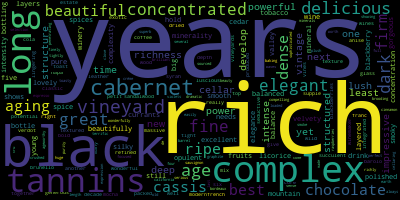

In [ ]:
cloud = WordCloud()
cloud.generate_from_frequencies(great_diff).to_image()

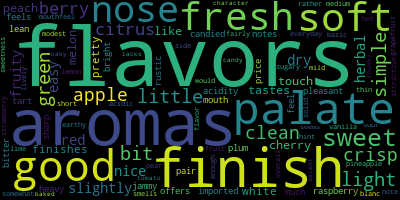

In [ ]:
cloud.generate_from_frequencies(mediocre_diff).to_image()

These give us a good sense of the words that distinguish good wines from mediocre wines. We'll finish up by making these visualizations more beautiful and on topic. (https://amueller.github.io/word_cloud/auto_examples/masked.html)

In [ ]:
from PIL import Image
from os import path
import os

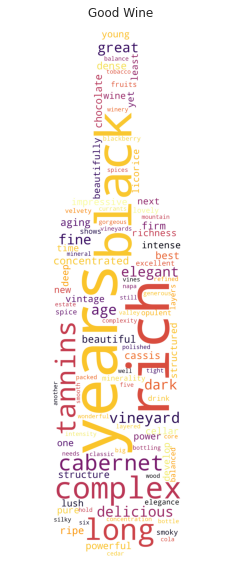

In [ ]:
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
wine_mask = np.array(Image.open(path.join(d, "wine_mask.png")))

def generate_wordcloud(data, title, mask=None):
    cloud = WordCloud(scale=3,
                      max_words=100,
                      colormap='inferno',
                      mask=mask,
                      background_color='white',
                      stopwords=stopwords,
                      collocations=True).generate_from_frequencies(data)
    plt.figure(figsize=(15,10))
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(title)
    plt.show()
    
# Use the function to create the word cloud for Good Wines  
generate_wordcloud(great_diff, 'Good Wine', mask=wine_mask)

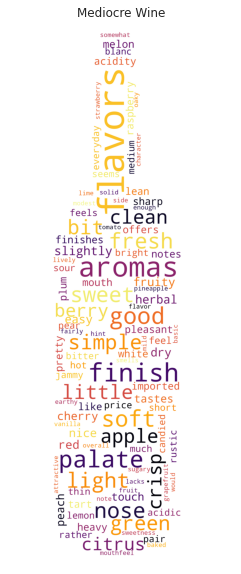

In [ ]:
# Use the function to create the word cloud for Mediocre Wines  
generate_wordcloud(mediocre_diff, 'Mediocre Wine', mask=wine_mask)

## **Document Classification with NLTK**
(Reference: https://www.nltk.org/book/ch06.html Section 1.3 Document Classification)

Let's take this analysis a step further! As we saw in our top 20 most commons words and the word clouds above, generally dark and rich wines are rated better than fruity, sweet wines. Let's see if we can use the wine descriptions and labels in `wine_reviews_df` to train a classifier predict whether a wine will be rated well (`label == 1`) or not so well (`label == 0`). 

We'll use document classification. Before we begin, we'll create a new dataframe called `wine_corpus`, keeping only the columns for wine `description` and `label`, where `label = 1` if the wine is well-rated and `label = 0` otherwise.

In [ ]:
wine_corpus = wine_reviews_df[['description', 'label']]

We'll do a quick check to make sure our `wine_corpus` has the desired columns.

In [ ]:
wine_corpus.head()

description  label
0  This tremendous 100% varietal wine hails from ...      1
1  Ripe aromas of fig, blackberry and cassis are ...      1
2  Mac Watson honors the memory of a wine once ma...      1
3  This spent 20 months in 30% new French oak, an...      1
4  This is the top wine from La Bégude, named aft...      1

For document classification, wines with no descriptions or unlabeled wines aren't going to be of much help, so let's go ahead and drop any rows where `label` is null. Let's also drop any duplicates, and make sure we reset the index to avoid headaches later on.

In [ ]:
wine_corpus.dropna(inplace=True)
wine_corpus.drop_duplicates(inplace=True)
wine_corpus.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Now, we'll construct a list of tuples to use in our document classification, where each tuple contains a wine description along with its appropriate label. In other words, `descriptions` is a list containing tuples of the form (`description`, `label`). We'll also randomly shuffle this list, since we'll take a subset of it later on to run our classifier on.

In [ ]:
labeled_tuples = list(wine_corpus.itertuples(index=False, name=None))
random.shuffle(labeled_tuples)

### Feature Extractor

Next, we'll define a feature extractor for wine descriptions. The goal is for our classifier to know which aspects of the data it should pay attention to. 

We'll define a feature for each word, indicating whether the description contains that word. To limit the number of features that the classifier needs to process, we'll obtain a list of the 2000 most frequent words in the overall corpus of wine descriptions, using the `nltk` library.

In [ ]:
tokens = great_tokens + mediocre_tokens 	
all_words = nltk.FreqDist(tokens)
word_features = list(all_words)[:2000]

We'll define a function as our feature extractor, which will check whether each of these 2000 most frequent words is present in each wine description.

In [ ]:
def document_features(document):
  document_words = set(tokenized_content(document))
  features = {}
  for word in word_features:
    features['contains({})'.format(word)] = (word in document_words)
  return features

### Naive Bayes Classifier

We'll use this feature extractor method to train a classifier to label new wine descriptions with 1 (good) or 0 (mediocre). We'll use `ntlk`'s Naive Bayes Classifier.

Note here that we take a random subset of 20,000 labeled tuples (which were randomly shuffled above). Using more data than this exceeds the RAM of the notebook.

In [ ]:
featuresets = [(document_features(d), c) for (d,c) in labeled_tuples[:20000]]
train_set, test_set = featuresets[100:], featuresets[:100]
classifier = nltk.NaiveBayesClassifier.train(train_set)

Let's see how accurate our classifier is! We'll compute its accuracy on the test set we defined above.

In [ ]:
print(nltk.classify.accuracy(classifier, test_set))

0.77


### Most Informative Features

We got a good sense of words that indicate good and mediocre wines from our word clouds. Let's investigate which features the classifier found to be most informative!

In [ ]:
classifier.show_most_informative_features(20)

Most Informative Features
      contains(everyday) = True                0 : 1      =     28.4 : 1.0
        contains(beauty) = True                1 : 0      =     22.7 : 1.0
      contains(gorgeous) = True                1 : 0      =     21.3 : 1.0
       contains(explode) = True                1 : 0      =     18.5 : 1.0
   contains(outstanding) = True                1 : 0      =     17.4 : 1.0
        contains(sugary) = True                0 : 1      =     16.1 : 1.0
    contains(immaculate) = True                1 : 0      =     15.8 : 1.0
        contains(superb) = True                1 : 0      =     15.7 : 1.0
      contains(threaded) = True                1 : 0      =     14.4 : 1.0
        contains(decade) = True                1 : 0      =     13.9 : 1.0
      contains(greatest) = True                1 : 0      =     13.6 : 1.0
       contains(endless) = True                1 : 0      =     13.0 : 1.0
 contains(magnificently) = True                1 : 0      =     13.0 : 1.0

What does this mean? In this corpus of wine descriptions, a descriptions that mentions "everyday" is 28.4 times more likely indicate a mediocre wine than a good wine, while a review that mentions "gorgeous" is 21.3 times more likely to indicate a good wine. These are pretty expected, but there are some surprises here, like "sugary" being around 16 times more likely to indicate a medicore wine!

## **Document Classification with SKLEARN**
(Reference: https://stackabuse.com/text-classification-with-python-and-scikit-learn/)

We've already tried out one classifier with the `nltk` library. Now let's try out some more classifiers using the powerful `scikit-learn` Python library. 

In this section, we'll do some text preprocessing, split our data into training and test sets, and train three classifiers on the data. We'll train a Naive Bayes classifier, a Logistic Regression classifier, and an SVM classifier.

In [ ]:
!pip install -U scikit-learn

In [ ]:
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Using our same `wine_corpus`, we'll obtain our feature vector X of `descriptions` and our label vector `y` of labels, 1 for good wine and 0 for medicore wine.

In [ ]:
X, y = wine_corpus.description, wine_corpus.label

### Text Preprocessing

We'll do a bit of preprocessing on the text, similar to how we tokenized the text in the previous section. Our wine descriptions might contain numbers, special characters, and whitespace. Let's go ahead and clean up the text.

Most of these cleaning steps are simple and performed with regular expressions. The final step is lemmatization, which reduces a word to its root form. For example, "wines" is converted to "wine," to avoid duplicate features for terms that are semantically similar but syntactically different.

In [ ]:
documents = []
stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # Remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b', a check for datasets in bytes format
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

### Bag-of-Words Model

Machine learning can't do much with raw text data, so we'll use the Bag-of-Words model, or BoW, to extract features from our text for use in modeling. The BoW converts the text into vectors of numbers by utilizing the vocabulary of known words and a measure of frequency of these words.

We'll use `sklearn`'s black box methods to create our vectors, but this reference (https://machinelearningmastery.com/gentle-introduction-bag-words-model/) was helpful for some backround info.We'll use the `CountVectorizer` class for feature extraction from our raw text. 

There are a *lot* of unique words in our dataset, so we'll just keep the 2000 most frequently occurring words to train our classifier. We specify this with `max_features = 2000`. We want to avoid words that don't appear in many descriptions, so we'll set `min_df = 5`, specifying that a feature should occur in at least 5 descriptions to be used. The parameter `max_df` specifies that we should only use words that occur in at most 70% of descriptions. If a word appears in too many descriptions, it describes nearly all wines and probably doesn't provide much helpful information. Finally, we'll avoid using stop words as features.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# obtain documents
vectorizer = CountVectorizer(max_features=2000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

We'll further enhance our feature set with TDIDF, or term frequency-inverse document frequency, a statistic that reflects how important a word is to a document or description in our corpus. This statistic helps adjust for the fact that some words appear more frequently across all descriptions rather than specific descriptions.
(https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

We're about to use supervised learning, so let's split our data into a training and testing set.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


## **Comparing ML Algorithms**

In the following section, we'll compare the accuracy of three different classifiers that we'll be using for binary classification of wine descriptions.


1.   Naive Bayes
2.   Logistic Regression
2.   SVM

### Naive Bayes Classifier

For each of our three classifiers, we'll follow a similar process:


*   Initialize our classifier
*   Fit the classifier on the training data
*   Use the classifier to predict labels on our test set
*   Obtain the R-squared/accuracy level of our classifier, as well as other classifier performance metrics (recall, precision, and F1)




In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
nb_predicted = nb_classifier.predict(X_test)

# R squared score
nb_test_accuracy = nb_classifier.score(X_test, y_test)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Precision
nb_precision = precision_score(y_test, nb_predicted)

# Recall
nb_recall = recall_score(y_test, nb_predicted)

# F1 score
nb_f1 = f1_score(y_test, nb_predicted)

In [ ]:
print(f'Accuracy for Naive Bayes: {nb_test_accuracy}')
print(f'Precision for Naive Bayes: {nb_precision}')
print(f'Recall for Naive Bayes: {nb_recall}')
print(f'F1 for Naive Bayes: {nb_f1}')

Accuracy for Naive Bayes: 0.8162944675120637
Precision for Naive Bayes: 0.7883211678832117
Recall for Naive Bayes: 0.5850078630089114
F1 for Naive Bayes: 0.6716148445336009


**ROC Curve**

We'll also plot an ROC curve for each classifier, a graph showing the performance of the model at all classification thresholds. The ROC curve plots the true positive rate against the false positive rate.

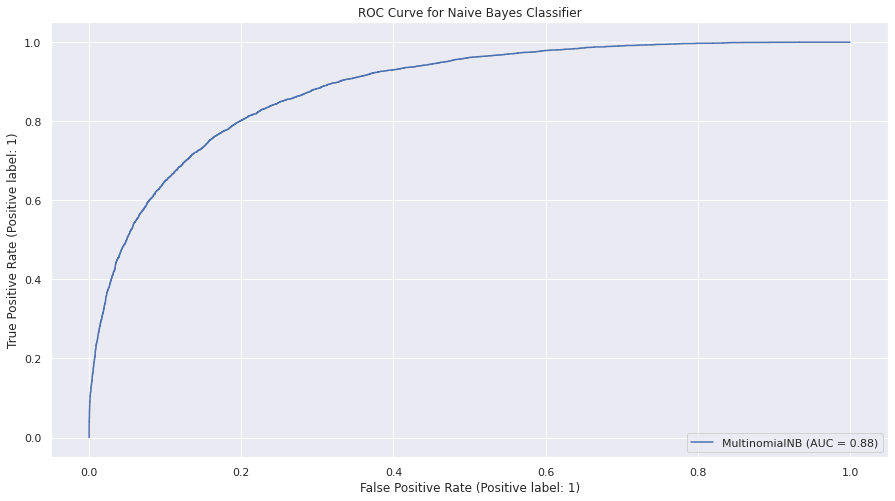

<Figure size 720x576 with 0 Axes>

In [ ]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(nb_classifier, X_test, y_test)
plt.title("ROC Curve for Naive Bayes Classifier")
plt.figure(figsize=(10,8))
plt.show()

**Confusion Matrix**

(Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

Another way to visualize our classification accuracy is with a confusion matrix. If our confusion matrix is called $C$, then slot *$C_{i,j}$* will indicate the number of observations that have label $i$ and are predicted to have label $j$.

In our homework, we used a Seaborn heatmap to visualize our confusion matrix. To make things easier, `sklearn` has built in functionality with `ConfusionMatrixDisplay`.

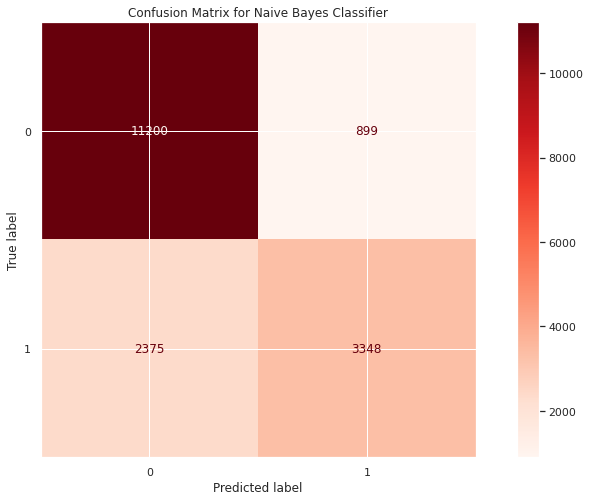

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, nb_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_classifier.classes_)
disp.plot(cmap='Reds')
plt.title('Confusion Matrix for Naive Bayes Classifier')
plt.show()

### Logistic Regression Classifier

Let's follow the same process as above, now with a logistic regression classifier.

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)
lr_predicted = lr_classifier.predict(X_test)

# R squared score
lr_test_accuracy = lr_classifier.score(X_test, y_test)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Precision
lr_precision = precision_score(y_test, lr_predicted)

# Recall
lr_recall = recall_score(y_test, lr_predicted)

# F1 score
lr_f1 = f1_score(y_test, lr_predicted)

In [ ]:
print(f'Accuracy for Logistic Regression: {lr_test_accuracy}')
print(f'Precision for Logistic Regression: {lr_precision}')
print(f'Recall for  Logistic Regression: {lr_recall}')
print(f'F1 for  Logistic Regression: {lr_f1}')

Accuracy for Logistic Regression: 0.8447985635731119
Precision for Logistic Regression: 0.7908715325595121
Recall for  Logistic Regression: 0.7024287960859689
F1 for  Logistic Regression: 0.7440310938367573


**ROC Curve**

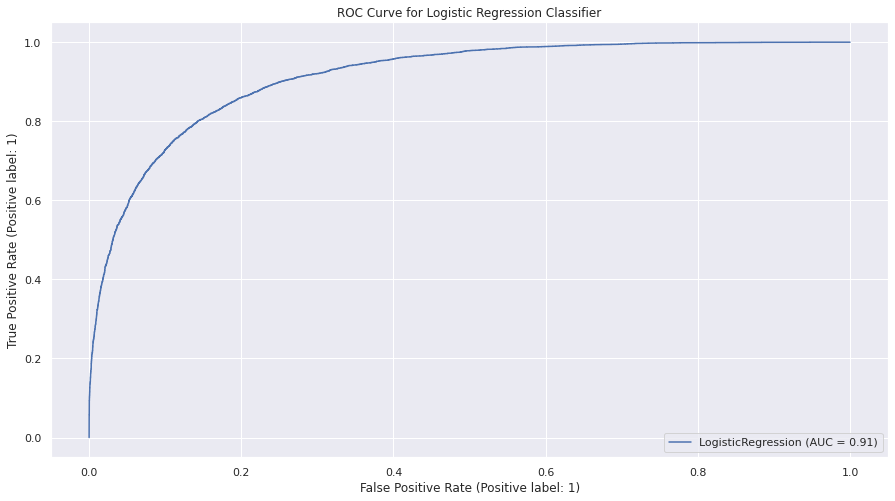

<Figure size 720x576 with 0 Axes>

In [ ]:
RocCurveDisplay.from_estimator(lr_classifier, X_test, y_test)
plt.title("ROC Curve for Logistic Regression Classifier")
plt.figure(figsize=(10,8))
plt.show()

**Confusion Matrix**

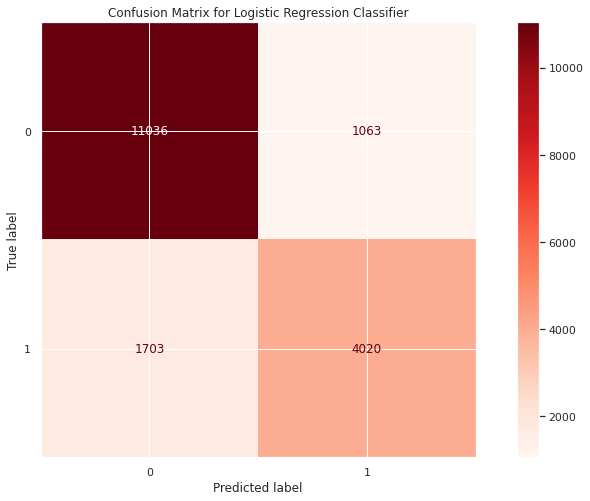

In [ ]:
cm = confusion_matrix(y_test, lr_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_classifier.classes_)
disp.plot(cmap='Reds')
plt.title('Confusion Matrix for Logistic Regression Classifier')
plt.show()

### SVM Classifier with SGD Training

Finally, we'll train a support vector machine (SVM) with stochastic gradient descent (SGD) learning.

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier()
sgd_classifier.fit(X_train, y_train)
sgd_predicted = sgd_classifier.predict(X_test)

# R squared score
sgd_test_accuracy = sgd_classifier.score(X_test, y_test)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Precision
sgd_precision = precision_score(y_test, sgd_predicted)

# Recall
sgd_recall = recall_score(y_test, sgd_predicted)

# F1 score
sgd_f1 = f1_score(y_test, sgd_predicted)

In [ ]:
print(f'Accuracy for SVM: {sgd_test_accuracy}')
print(f'Precision for SVM: {sgd_precision}')
print(f'Recall for SVM: {sgd_recall}')
print(f'F1 for SVM: {sgd_f1}')

Accuracy for SVM: 0.835708674671754
Precision for SVM: 0.8228228228228228
Recall for SVM: 0.6224008387209505
F1 for SVM: 0.7087146836450458


**ROC Curve**

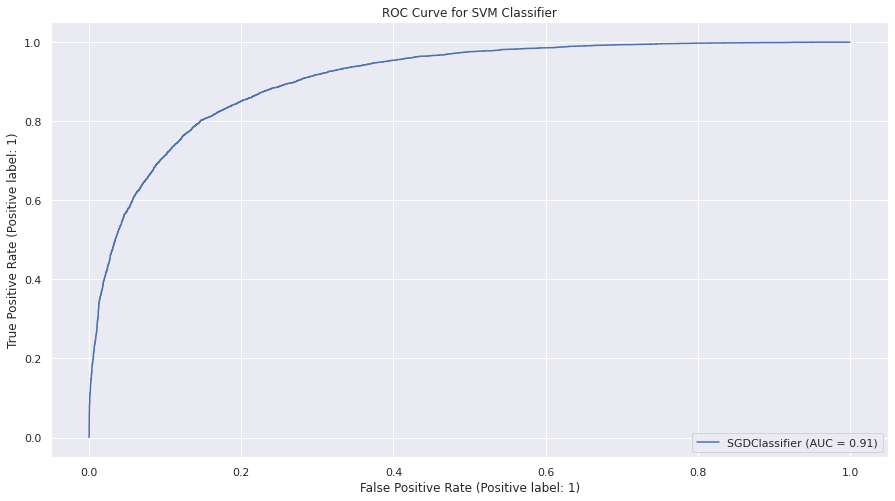

<Figure size 720x576 with 0 Axes>

In [ ]:
RocCurveDisplay.from_estimator(sgd_classifier, X_test, y_test)
plt.title("ROC Curve for SVM Classifier")
plt.figure(figsize=(10,8))
plt.show()

**Confusion Matrix**

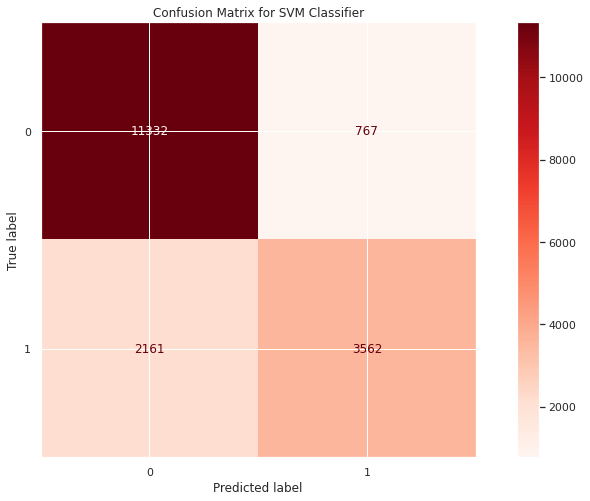

In [ ]:
cm = confusion_matrix(y_test, sgd_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sgd_classifier.classes_)
disp.plot(cmap='Reds')
plt.title('Confusion Matrix for SVM Classifier')
plt.show()

### Comparison of trained classifiers
Now that we've trained and evaluated each of these three classifiers, let's see how they compare on each performance metric. We'll use the Python `tabulate` to format a table containing the accuracy, F1, precision, and recall for our three classifiers.

In [ ]:

table = [['', 'Naive Bayes', 'Logistic Regression', 'SVM'], 
         ['Accuracy', nb_test_accuracy, lr_test_accuracy, sgd_test_accuracy], 
         ['Precision', nb_precision, lr_precision, sgd_precision],
         ['Recall', nb_recall, lr_recall, sgd_recall],
         ['F1', nb_f1, lr_f1, sgd_f1]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════╤═══════════════╤═══════════════════════╤══════════╕
│           │   Naive Bayes │   Logistic Regression │      SVM │
╞═══════════╪═══════════════╪═══════════════════════╪══════════╡
│ Accuracy  │      0.816294 │              0.844799 │ 0.835709 │
├───────────┼───────────────┼───────────────────────┼──────────┤
│ Precision │      0.788321 │              0.790872 │ 0.822823 │
├───────────┼───────────────┼───────────────────────┼──────────┤
│ Recall    │      0.585008 │              0.702429 │ 0.622401 │
├───────────┼───────────────┼───────────────────────┼──────────┤
│ F1        │      0.671615 │              0.744031 │ 0.708715 │
╘═══════════╧═══════════════╧═══════════════════════╧══════════╛


Our logistic regression classifier had the best accuracy of the three classifiers, the best recall or sensitivity (true positivity rate), as well as the highest F1 value. SVM had the best precision, or positive predicted value (PPV). 

Naive Bayes performed worst in all performance metrics, with a particularly low recall. This means Naive Bayes had a high number of false negatives (which we do see in the confuison matrix). This might be an outcome of untuned model hyperparameters. It's also likely this is an outcome of imbalanced class; we had far more wines labeled with 0 than 1, and all classifiers had lower recall than othe performance metrics.

# Reflections



In this notebook, we sought to train models that could act as wine sommeliers. Some of our models took into consideration the location of origin and associated heat factors of wines and price to predict wine rating. Some took into consideration the rating instead to predict price. And some were trained on descriptions of wines -- our replacement the sensation of taste.

### Takeaways

There are a few takeaways from our experimentation with regard to the development of a models using both numeric and text data.

1. Simpler Models Often Work Better. Our original dataset doesn't contain too many features, and we found that our simplest models, the binary classifiers, performed best. On the numeric models our linear regression and logistic regression classifiers did just as well if not better than our other classifiers, showing that it was not necessary to use numeric models to conduct such prediction. For our random forest, parameter tuning with RandomizedSearchCSV resulted in a lower accuracy score than the default. This project taught us the importance of creating models with the complexity of the dataset in mind. 

2. Text Predictors: Text predictors are often better at overall predictions than non-text predictors for text! Given the number values and the lack of many dimensions for our numeric predictors we felt that we could do much better with our text predictors.

3. Auxilliary Insight: Our texts models were also often able to give us great auxilliary insight into the most important words in reviews (with regard to overall intention) which helped us better understand our models.

### Challenges

1.	Determining how to encode data: Since our data was mostly text, we faced several issues with determining how to encode the data in a numeric format, and hence had to resort to a manual encoding system on the basis of heat. While this is a pretty good heuristic, a further step here could also be trying out other heuristics and generating predictive models.

2.	Visualising Text Data: We looked for several ways to visualise text data and often ended up not being able to best convey our message. In the end we used a range of visualisations to ensure our data is best conveyed.

3.	Developing Text Models: Given that the most important question we wanted to answer was about wine descriptions and reviews, we faced challenges with choosing the best text ML models and hence decided to go beyond the course topics and include cutting-edge models to help best answer our questions.

### Next steps
Many of the issues with our numerical classifiers came from the fact that our wine data lacked in numerical features or categorical features that could be intuitively encoded as numerical. It would be interesting to find a dataset of wine reviews with more features, or find a dataset to join or merge with the one we used. 

For our text based classifiers, we stuck to the default parameters, but some a future step would be some hyperparamter tuning, which might increase the accuracy and recall of our classifiers.

It might also be interesting to flip around our hypothesis, and see if we can predict wine price from rating and various other features!
_______________

Thanks for reading! Go enjoy a glass of `gorgeous`, `immaculate`, `beautiful` wine! It would be quite likely to be a good glass :)